## **Table of Contents**
* [Goals](#1)
* [About Data](#2)
* [Data cleaning](#3)
* [Exploring the Target](#4)
* [Exploring the Features](#5)
* [Target vs Features](#6)
* [Building the Pipeline](#7)
* [Model Selection w/o Feature Engineering](#8)
* [Model Selection with Feature Engineering](#9)
* [Tuning the Hyperparameters](#10)
* [Final Evaluation](#11)
* [Feature Importances](#12)

<a id='1'></a>
# **Goals**

- To utilize **Gradient Boosting** and effective **Feature Engineering** to predict the invariant mass of two electrons resulting from particle collision events.

- To streamline the procedure by chaining steps of the machine learning workflow together using Sklearn's **Pipeline** framework.

<a id='2'></a>
# **About Data**

Released by CMS, this dataset contains data on 100,000 dielectron events in the invarient mass range 2-110 GeV, which involve the production of an electron and a position (an anti-electron). 

The features are not self-explanatory, so here is a copy of the data description:

* Run: The run number of the event.
* Event: The event number.
* E1, E2: The total energy of the electron (GeV) for electrons 1 and 2.
* px1, py1, pz1, px2, py2, pz2: The components of the momemtum of the electron 1 and 2 (GeV).
* pt1, pt2: The transverse momentum of the electron 1 and 2 (GeV).
* eta1, eta2: The pseudorapidity of the electron 1 and 2.
* phi1, phi2: The phi angle of the electron 1 and 2 (rad).
* Q1, Q2: The charge of the electron 1 and 2.
* M: The invariant mass of two electrons (GeV) <= OUR TARGET

<a id='3'></a>
# **Data Cleaning**

In [2]:
# Essentials
import pandas as pd
import numpy as np

# Progress bar
from tqdm.notebook import tqdm
from tqdm import trange
tqdm.pandas()

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
sns.set_theme(style="ticks") 
%matplotlib inline

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.neighbors import LocalOutlierFactor

# Pipeline
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion, make_union
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import set_config
set_config(display="diagram")  # make pipeline visible
set_config(transform_output="pandas")  # make transformers output pandas dataframe

# Models
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Metrics and evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
shap.initjs()

# Hyperparameter Tuning
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Ignore warnings
pd.options.mode.chained_assignment = None 

In [3]:
# Loading data
CERN = pd.read_csv("../data/raw/dielectron.csv")

# Copy to protect original data
df = CERN.copy()

# Preview data
df.head()

Run      Event        E1      px1         py1       pz1       pt1  \
0  147115  366639895  58.71410  -7.31132  10.531000 -57.29740  12.82020   
1  147115  366704169   6.61188  -4.15213  -0.579855  -5.11278   4.19242   
2  147115  367112316  25.54190 -11.48090   2.041680  22.72460  11.66100   
3  147115  366952149  65.39590   7.51214  11.887100  63.86620  14.06190   
4  147115  366523212  61.45040   2.95284 -14.622700 -59.61210  14.91790   

      eta1     phi1  Q1       E2        px2      py2      pz2       pt2  \
0 -2.20267  2.17766   1  11.2836  -1.032340 -1.88066 -11.0778   2.14537   
1 -1.02842 -3.00284  -1  17.1492 -11.713500  5.04474  11.4647  12.75360   
2  1.42048  2.96560   1  15.8203  -1.472800  2.25895 -15.5888   2.69667   
3  2.21838  1.00721   1  25.1273   4.087860  2.59641  24.6563   4.84272   
4 -2.09375 -1.37154  -1  13.8871  -0.277757 -2.42560 -13.6708   2.44145   

       eta2      phi2  Q2         M  
0 -2.344030 -2.072810  -1   8.94841  
1  0.808077  2.734920   1  15.89300  
2 -2.455080  2.148570   1  38.38770  
3  2.330210  0.565865  -1   3.72862  
4 -2.423700 -1.684810  -1   2.74718

In [4]:
# Dimensions
df.shape

(100000, 19)

In [5]:
# Structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Run     100000 non-null  int64  
 1   Event   100000 non-null  int64  
 2   E1      100000 non-null  float64
 3   px1     100000 non-null  float64
 4   py1     100000 non-null  float64
 5   pz1     100000 non-null  float64
 6   pt1     100000 non-null  float64
 7   eta1    100000 non-null  float64
 8   phi1    100000 non-null  float64
 9   Q1      100000 non-null  int64  
 10  E2      100000 non-null  float64
 11  px2     100000 non-null  float64
 12  py2     100000 non-null  float64
 13  pz2     100000 non-null  float64
 14  pt2     100000 non-null  float64
 15  eta2    100000 non-null  float64
 16  phi2    100000 non-null  float64
 17  Q2      100000 non-null  int64  
 18  M       99915 non-null   float64
dtypes: float64(15), int64(4)
memory usage: 14.5 MB


In [6]:
# Statistical summary
df.describe().T

count          mean           std            min           25%  \
Run    100000.0  1.479353e+05  9.203061e+02  146511.000000  1.471140e+05   
Event  100000.0  4.957212e+08  4.037703e+08    6414.000000  2.023970e+08   
E1     100000.0  3.643647e+01  4.121620e+01       0.377928  8.458595e+00   
px1    100000.0  1.358968e-01  1.340498e+01    -250.587000 -5.233675e+00   
py1    100000.0  1.822913e-01  1.347028e+01    -126.079000 -5.276248e+00   
pz1    100000.0 -1.508037e+00  5.160365e+01    -840.987000 -1.585983e+01   
pt1    100000.0  1.441217e+01  1.238874e+01       0.219629  3.771172e+00   
eta1   100000.0 -6.409547e-02  1.462137e+00      -4.165380 -1.283883e+00   
phi1   100000.0  2.161430e-02  1.799562e+00      -3.141580 -1.527030e+00   
Q1     100000.0 -5.480000e-03  9.999900e-01      -1.000000 -1.000000e+00   
E2     100000.0  4.400290e+01  4.675113e+01       0.472500  1.105572e+01   
px2    100000.0 -3.983566e-03  1.312740e+01    -233.730000 -4.794770e+00   
py2    100000.0  1.246539e-01  1.316887e+01    -145.651000 -4.605965e+00   
pz2    100000.0 -1.590559e+00  6.143004e+01    -655.396000 -2.203695e+01   
pt2    100000.0  1.380204e+01  1.246055e+01       0.026651  3.738103e+00   
eta2   100000.0 -7.282961e-02  1.738033e+00      -7.064790 -1.892287e+00   
phi2   100000.0  2.138491e-02  1.817031e+00      -3.141580 -1.556925e+00   
Q2     100000.0 -4.220000e-03  9.999961e-01      -1.000000 -1.000000e+00   
M       99915.0  3.001952e+01  2.525585e+01       2.000080  1.244520e+01   

                50%           75%           max  
Run    1.479290e+05  1.490110e+05  1.491820e+05  
Event  3.902759e+08  6.338891e+08  1.791247e+09  
E1     2.171700e+01  5.000335e+01  8.506020e+02  
px1    1.413385e-01  5.714560e+00  1.345390e+02  
py1    9.909205e-02  5.648087e+00  1.474670e+02  
pz1   -3.129870e-01  1.321265e+01  7.600960e+02  
pt1    1.296780e+01  2.001892e+01  2.655780e+02  
eta1  -6.117850e-02  1.144408e+00  2.622970e+00  
phi1   3.432395e-02  1.562355e+00  3.141420e+00  
Q1    -1.000000e+00  1.000000e+00  1.000000e+00  
E2     2.526460e+01  6.692552e+01  9.483750e+02  
px2   -3.563795e-02  4.819540e+00  2.273300e+02  
py2    8.366450e-02  5.061860e+00  1.662830e+02  
pz2   -6.902445e-01  1.900583e+01  9.355580e+02  
pt2    1.169095e+01  1.959640e+01  2.816540e+02  
eta2  -1.359110e-01  1.768253e+00  3.060550e+00  
phi2   2.698635e-02  1.596737e+00  3.141290e+00  
Q2    -1.000000e+00  1.000000e+00  1.000000e+00  
M      2.128310e+01  3.902505e+01  1.099990e+02

In [7]:
# Array of column names
df.columns

Index(['Run', 'Event', 'E1', 'px1 ', 'py1', 'pz1', 'pt1', 'eta1', 'phi1', 'Q1',
       'E2', 'px2', 'py2', 'pz2', 'pt2', 'eta2', 'phi2', 'Q2', 'M'],
      dtype='object')

In [8]:
# Removing trailing whitespace from 'px1 ' column name
df.rename(columns={"px1 ": "px1"}, inplace=True)

In [9]:
# Checking for duplicate rows
df.duplicated().sum()

23

There are 23 duplicate rows. Lets see which events are recorded more than once:

In [10]:
# Counting the number of events and filtering events with more than 1 count
df["Event"].value_counts()

Event
439950319    3
440012942    3
542369397    2
541746848    2
407103633    2
            ..
533929729    1
533477001    1
533722800    1
533379552    1
524172389    1
Name: count, Length: 99976, dtype: int64

Multiple events are recorded more than once.

In [11]:
# Extracting a list of the Event IDs with more than 1 count
dup_ids = df["Event"].value_counts()[df["Event"].value_counts() > 1].index.tolist()

# And showing the corresponding rows
df[df["Event"].isin(dup_ids)].sort_values(by="Event")

Run      Event         E1        px1        py1        pz1  \
97032  146511  337473110   15.71730   2.243060  -2.982110   15.26790   
96984  146511  337473110   15.71730   2.243060  -2.982110   15.26790   
97033  146511  337653458   17.69410  -4.451330  16.592600   -4.23684   
96985  146511  337653458   17.69410  -4.451330  16.592600   -4.23684   
96986  146511  337851094    3.85730   1.011940  -3.335790    1.65144   
97034  146511  337851094    3.85730   1.011940  -3.335790    1.65144   
97035  146511  338078762   18.47870   5.565370  11.268000   13.54700   
96987  146511  338078762   18.47870   5.565370  11.268000   13.54700   
97015  146511  406690266   12.43280  -2.900320   1.974970   11.92740   
96988  146511  406690266   12.43280  -2.900320   1.974970   11.92740   
97016  146511  407076179   25.66740  -0.652954 -19.565100  -16.60110   
96989  146511  407076179   25.66740  -0.652954 -19.565100  -16.60110   
97017  146511  407103633  147.57400 -26.959900 -19.961900 -143.71100   
96990  146511  407103633  147.57400 -26.959900 -19.961900 -143.71100   
79612  148029  418006834   21.83980 -19.431400  -9.038480   -4.20742   
39064  147114  418006834   18.77890   5.743590   7.402630  -16.27450   
73921  148029  439950319  170.04500 -33.420600  12.421300  166.26500   
73919  148029  439950319  170.04500 -33.420600  12.421300  166.26500   
73917  148029  439950319  170.04500 -33.420600  12.421300  166.26500   
73922  148029  440012942   15.36380  13.108800   1.828450    7.80152   
73920  148029  440012942   15.36380  13.108800   1.828450    7.80152   
73918  148029  440012942   15.36380  13.108800   1.828450    7.80152   
60188  147754  518989177    8.33115   2.400990  -0.130240   -7.97661   
60186  147754  518989177    8.33115   2.400990  -0.130240   -7.97661   
60187  147754  519135297   22.13280  -6.448970 -12.952100   16.74860   
60189  147754  519135297   22.13280  -6.448970 -12.952100   16.74860   
67016  147754  541649129   36.80810  14.499400 -31.448200   12.47450   
60193  147754  541649129   36.80810  14.499400 -31.448200   12.47450   
60195  147754  541661621   40.64410 -12.206200  15.866800   35.37230   
67018  147754  541661621   40.64410 -12.206200  15.866800   35.37230   
67019  147754  541668133   24.84330   1.098180  -5.613480  -24.17590   
60196  147754  541668133   24.84330   1.098180  -5.613480  -24.17590   
67017  147754  541673578   17.44490 -14.769900   8.991270   -2.30926   
60194  147754  541673578   17.44490 -14.769900   8.991270   -2.30926   
67014  147754  541698960   14.06170  -3.846410  -3.274200  -13.12310   
60191  147754  541698960   14.06170  -3.846410  -3.274200  -13.12310   
60192  147754  541746848   11.13010   5.371560  -4.526660   -8.63329   
67015  147754  541746848   11.13010   5.371560  -4.526660   -8.63329   
60198  147754  541754934   32.03840 -15.852000   0.151803   27.84150   
67021  147754  541754934   32.03840 -15.852000   0.151803   27.84150   
60199  147754  542302783   23.75810  18.350700   4.678030   14.34630   
67022  147754  542302783   23.75810  18.350700   4.678030   14.34630   
67020  147754  542369397    6.51714   5.005570  -4.027120   -1.09528   
60197  147754  542369397    6.51714   5.005570  -4.027120   -1.09528   
67023  147754  542510767   29.75620  23.766300   0.575109   17.89580   
60200  147754  542510767   29.75620  23.766300   0.575109   17.89580   

            pt1      eta1      phi1  Q1         E2        px2        py2  \
97032   3.73153  2.116690 -0.925907   1   56.61260 -19.624500   5.329360   
96984   3.73153  2.116690 -0.925907   1   56.61260 -19.624500   5.329360   
97033  17.17930 -0.244190  1.832900  -1    2.52616  -0.339374  -2.212630   
96985  17.17930 -0.244190  1.832900  -1    2.52616  -0.339374  -2.212630   
96986   3.48590  0.457610 -1.276260   1   38.52790 -20.602700  -3.118160   
97034   3.48590  0.457610 -1.276260   1   38.52790 -20.602700  -3.118160   
97035  12.56740  0.935430  1.112030  -1   11.90390   4.304320  -1.136620   
96987  12.56740  

These are all duplicate events, with the exception of 'Event'=418006834:

In [12]:
df[df["Event"] == 418006834]

Run      Event       E1       px1      py1       pz1       pt1  \
39064  147114  418006834  18.7789   5.74359  7.40263 -16.27450   9.36951   
79612  148029  418006834  21.8398 -19.43140 -9.03848  -4.20742  21.43070   

           eta1      phi1  Q1        E2       px2      py2       pz2      pt2  \
39064 -1.319410  0.910934   1  61.61360  23.14570  5.76582 -56.80910  23.8530   
79612 -0.195087 -2.706210  -1   7.19454  -6.13848 -1.89557  -3.23839   6.4245   

           eta2      phi2  Q2         M  
39064 -1.602350  0.244141   1  10.66540  
79612 -0.484849 -2.842080   1   3.76546

Weirdly, the two rows are even from different runs...maybe a bug?

In [13]:
# Correct this by changing the Event ID of the second row to new unique ID
df.loc[79612, "Event"] = 418006835

# And adjusting our list of duplicate IDs
dup_ids.remove(418006834)

# Check that it worked
df[df["Event"] == 418006834]

Run      Event       E1      px1      py1      pz1      pt1  \
39064  147114  418006834  18.7789  5.74359  7.40263 -16.2745  9.36951   

          eta1      phi1  Q1       E2      px2      py2      pz2     pt2  \
39064 -1.31941  0.910934   1  61.6136  23.1457  5.76582 -56.8091  23.853   

          eta2      phi2  Q2        M  
39064 -1.60235  0.244141   1  10.6654

Finally, remove the remaining duplicates since these events have the same data.

In [14]:
# Dropping the duplicate events
df = df.drop_duplicates(subset="Event")

In [15]:
# Checking that it worked
df.duplicated().sum()

0

In [16]:
# Checking missing values
df.isnull().sum()

Run       0
Event     0
E1        0
px1       0
py1       0
pz1       0
pt1       0
eta1      0
phi1      0
Q1        0
E2        0
px2       0
py2       0
pz2       0
pt2       0
eta2      0
phi2      0
Q2        0
M        85
dtype: int64

There are 85 rows with a missing target value (M). Since this is only a small fraction of the data (<0.001%), we can safely drop these rows.

In [17]:
# Drop rows with missing values
df = df.dropna(subset=["M"])

# Checking that it worked
print("Number of missing values after dropping rows: ", df.isnull().sum().sum())

Number of missing values after dropping rows:  0


In [18]:
# Saving the cleaned data
df.to_csv("../data/processed/01_cleaned.csv", index=False)

<a id='4'></a>
# **Exploring the Target**

In [19]:
# Defining the target variable
target = "M"

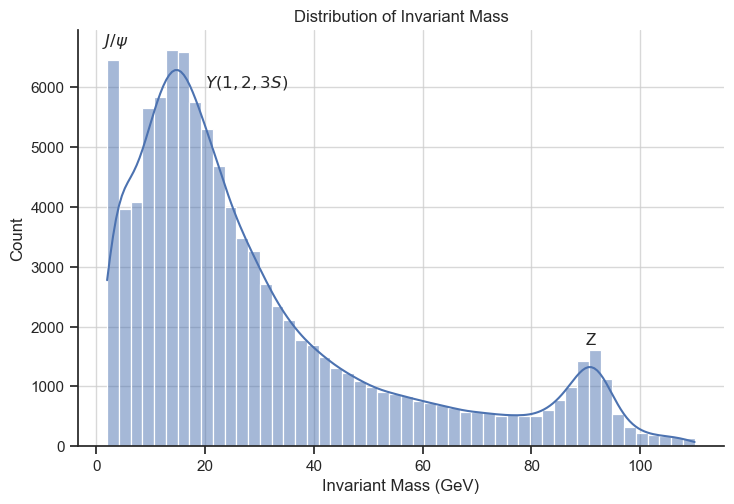

In [20]:
# Histogram of the target variable
sns.displot(df[target], bins=50, kde=True, aspect=1.5)
plt.title("Distribution of Invariant Mass")

# Gridlines
plt.grid(alpha=0.75)

# X-label
plt.xlabel("Invariant Mass (GeV)")

# Annotations
plt.annotate("Z", xy=(90, 1700))  # Z boson
plt.annotate("$J/\\psi$", xy=(1, 6700))  # J/psi meson
plt.annotate("$Y(1,2,3S)$", xy=(20, 6000))  # Upsilon meson

plt.show()

Interesting shape. We see three invarient mass peaks at approximately 3 GeV, 10 GeV and 90 GeV. 

These peaks represent the J/psi meson, the Y mesons and the Z boson respectively.

Quick explanation: 

Invariant mass peaks in a distribution of decay products (e+ and e- in our case) typically represent the mass of a parent particle that decayed to produce those products. 
When a particle decays, the invariant mass of the resulting decay products will be clustered around the mass of the parent particle. 
This is because, according to conservation laws, the total energy and momentum before and after the decay must be the same, and the invariant mass is a way to calculate this.


<a id='5'></a>
# **Exploring the Features**

* **Numerical** features

In [21]:
# List of numerical features
numerical_features = [
    "E1",
    "px1",
    "py1",
    "pz1",
    "pt1",
    "eta1",
    "phi1",
    "E2",
    "px2",
    "py2",
    "pz2",
    "pt2",
    "eta2",
    "phi2",
]

In [22]:
# Statistical summary of numerical features
df[numerical_features].describe().T

count       mean        std         min        25%        50%  \
E1    99892.0  36.459695  41.223335    0.377928   8.471438  21.740300   
px1   99892.0   0.136384  13.408913 -250.587000  -5.236865   0.141563   
py1   99892.0   0.183445  13.475059 -126.079000  -5.282197   0.100481   
pz1   99892.0  -1.512384  51.623350 -840.987000 -15.899575  -0.313852   
pt1   99892.0  14.417882  12.391571    0.219629   3.773227  12.972400   
eta1  99892.0  -0.064220   1.462644   -4.165380  -1.284752  -0.061568   
phi1  99892.0   0.021958   1.799509   -3.141580  -1.526615   0.035074   
E2    99892.0  44.030701  46.763373    0.472500  11.069550  25.292400   
px2   99892.0  -0.002902  13.130931 -233.730000  -4.793865  -0.035024   
py2   99892.0   0.125600  13.172812 -145.651000  -4.605640   0.084412   
pz2   99892.0  -1.590087  61.457682 -655.396000 -22.062375  -0.694057   
pt2   99892.0  13.805510  12.464594    0.026651   3.738480  11.692300   
eta2  99892.0  -0.072900   1.738682   -7.064790  -1.893003  -0.136785   
phi2  99892.0   0.021667   1.816894   -3.141580  -1.556020   0.027410   

            75%        max  
E1    50.063975  850.60200  
px1    5.719105  134.53900  
py1    5.652223  147.46700  
pz1   13.231550  760.09600  
pt1   20.026275  265.57800  
eta1   1.145393    2.62297  
phi1   1.562642    3.14142  
E2    66.984775  948.37500  
px2    4.819960  227.33000  
py2    5.063548  166.28300  
pz2   19.045400  935.55800  
pt2   19.602000  281.65400  
eta2   1.769330    3.06055  
phi2   1.596837    3.14129

  0%|          | 0/14 [00:00<?, ?it/s]

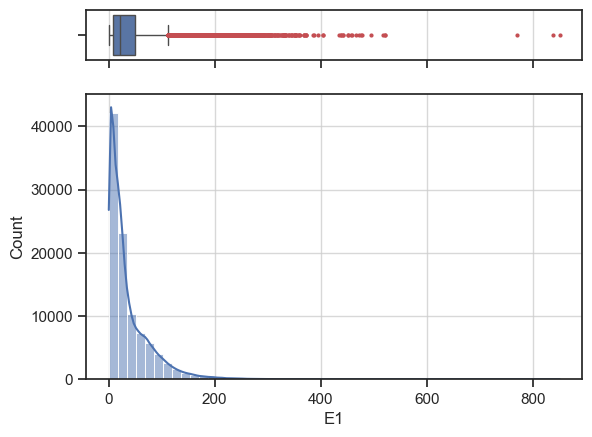

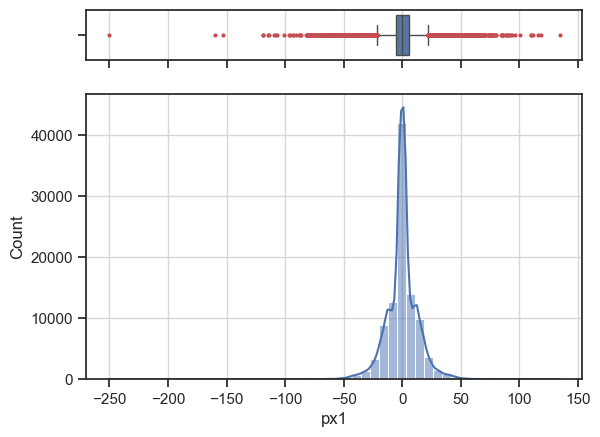

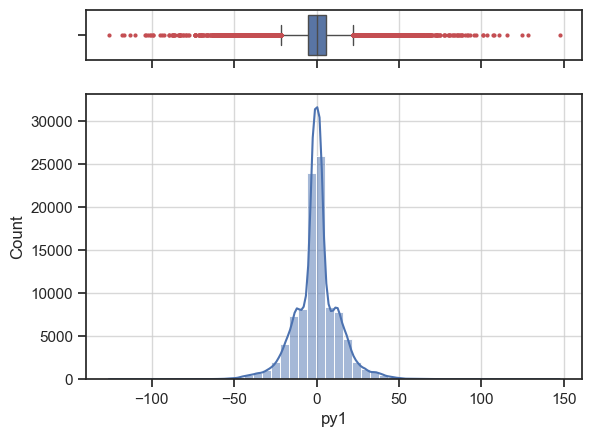

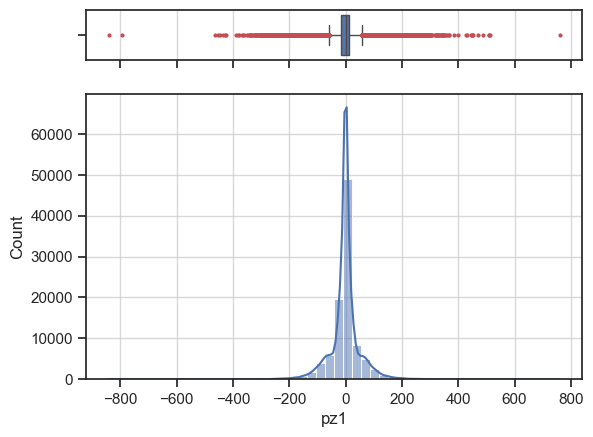

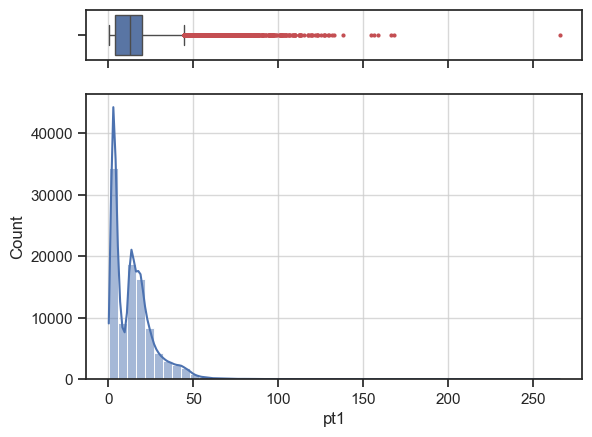

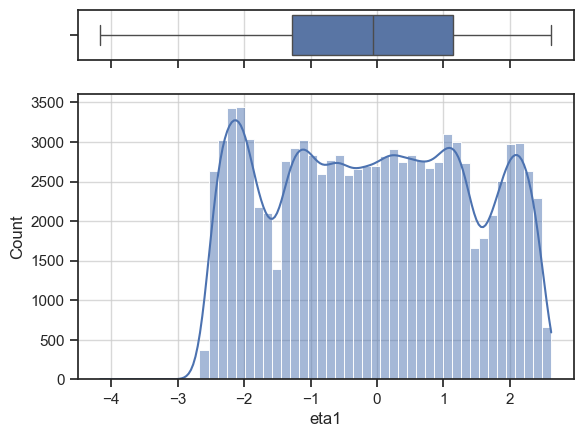

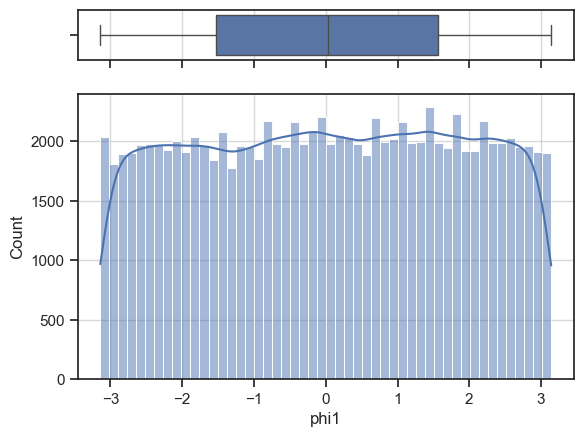

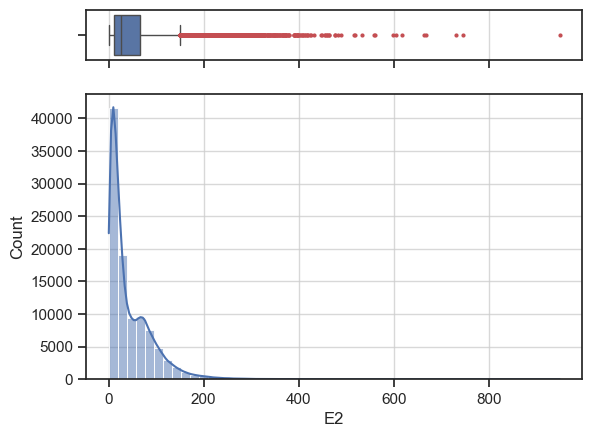

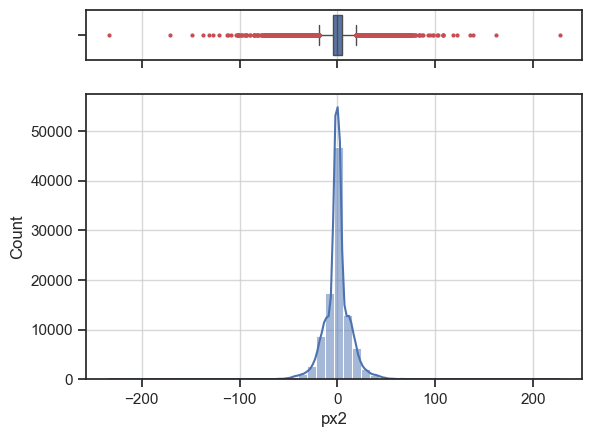

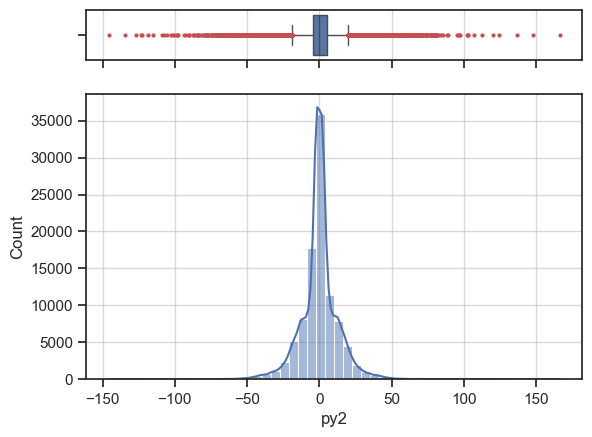

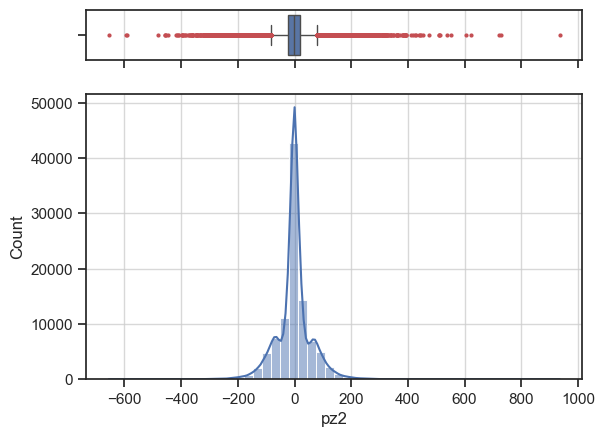

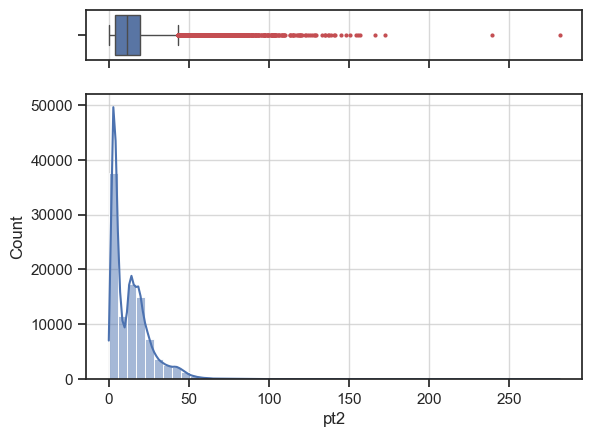

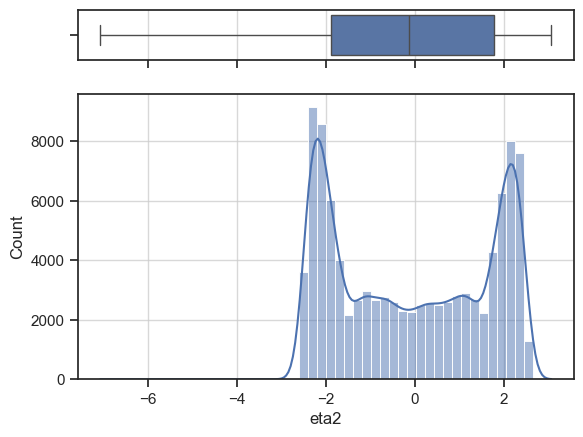

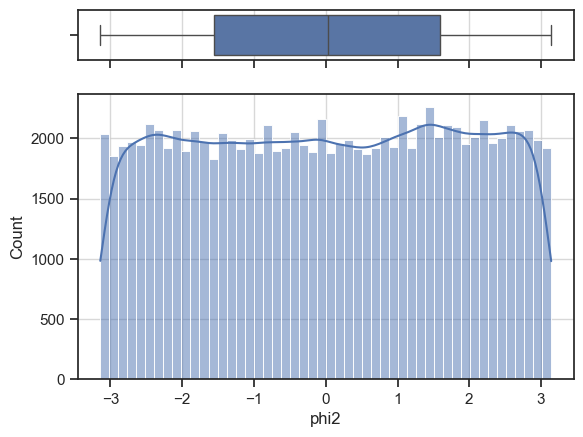

In [23]:
# Histogram / Boxplot of numerical features
for f in tqdm(numerical_features):
    fig, (ax_box, ax_hist) = plt.subplots(
        2, sharex=True, gridspec_kw={"height_ratios": (0.15, 0.85)}
    )

    # Gridlines
    ax_box.grid(alpha=0.75)
    ax_hist.grid(alpha=0.75)

    # Customizing the flier properties
    flierprops = dict(
        markerfacecolor="r", markersize=2, linestyle="none", markeredgecolor="r"
    )

    # Adding a graph in each part
    sns.boxplot(df[f], orient="h", ax=ax_box, flierprops=flierprops)
    sns.histplot(df[f], ax=ax_hist, bins=50, kde=True)

    # Remove x axis name for the boxplot
    ax_box.set(xlabel="")
    plt.show()

Summary of numerical feature plots:

* E1, E2: Both have a long tail to the right, with a few outliers
* px1, px2: Both normally distributed, with a few outliers
* py1, py2: Both normally distributed, with a few outliers
* pz1, pz2: Both normally distributed, with a few outliers
* pt1, pt2: Both have two peaks, tail off to the right, with a few outliers
* eta1, eta2: Both have peaks at either end, with no outliers
* phi1, phi2: Both uniformly distributed, with no outliers

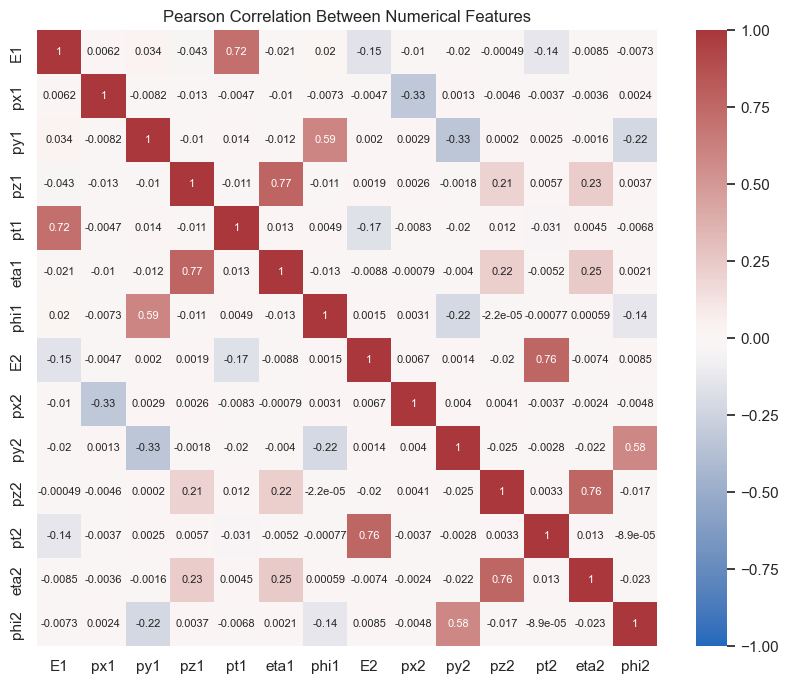

In [24]:
# Pearson correlation
corr_pearson = df[numerical_features].corr(method="pearson")

# Plotting the correlation matrix as a heatmap
fig = plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_pearson, annot=True, cmap="vlag", vmin=-1, vmax=1, annot_kws={"size": 8}
)
plt.tick_params(axis="both", which="both", bottom=False, left=False)  # Removing ticks
plt.title("Pearson Correlation Between Numerical Features")
plt.show()

**Highly correlated** numerical features are:
* E1 and pt1
* py1 and phi1
* pz1 and eta1
* E2 and pt2
* py2 and phi2
* pz2 and eta2

Lets investigate these correlations further with scatter plots.

  0%|          | 0/6 [00:00<?, ?it/s]

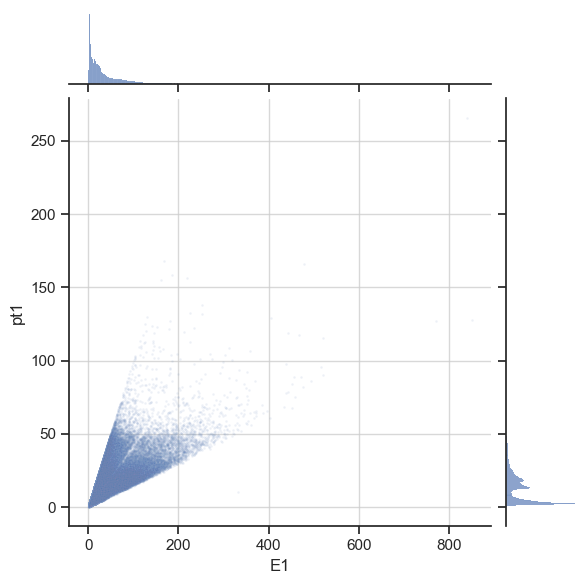

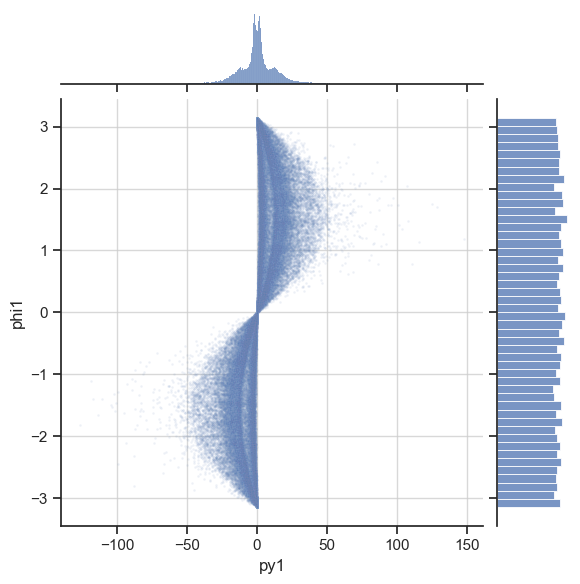

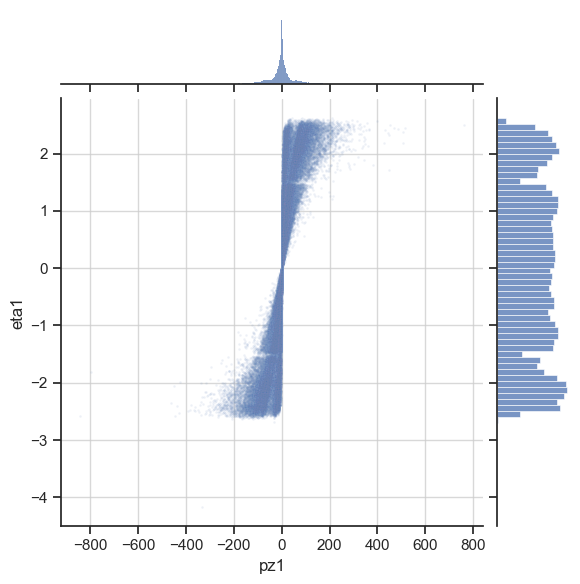

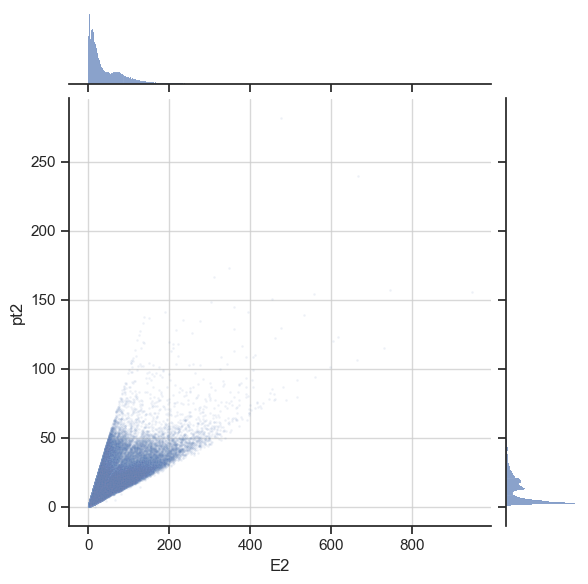

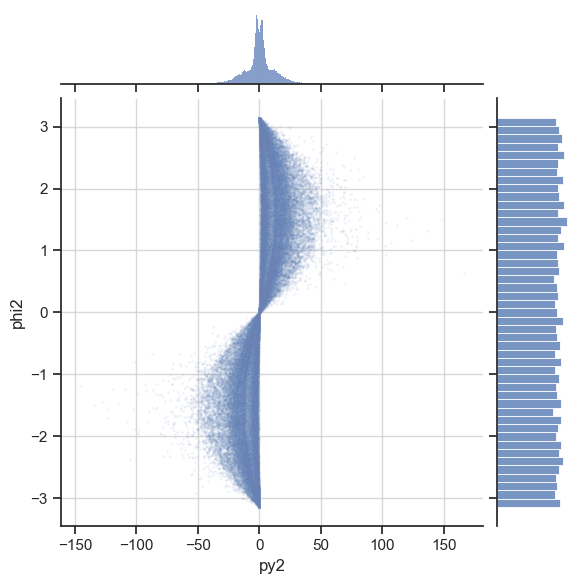

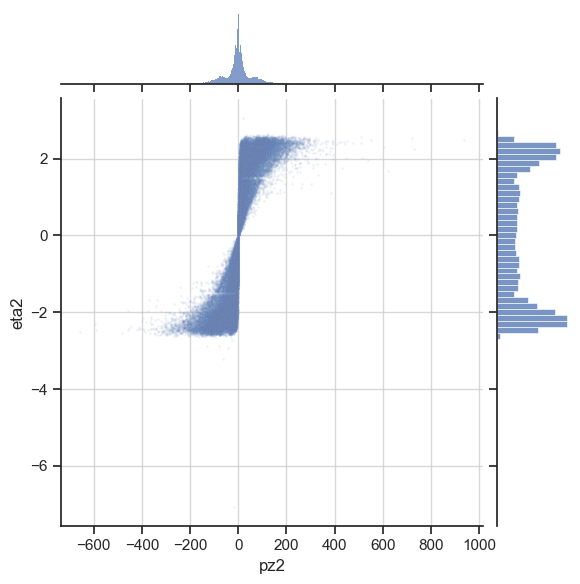

In [25]:
# Nested list of highly correlated features
high_corr = [
    ["E1", "pt1"],
    ["py1", "phi1"],
    ["pz1", "eta1"],
    ["E2", "pt2"],
    ["py2", "phi2"],
    ["pz2", "eta2"],
]

# Scatter plots of highly correlated features
for i in tqdm(high_corr):
    sns.jointplot(x=i[0], y=i[1], data=df, s=3, alpha=0.1)  # Scatter plot
    corr = df[i[0]].corr(df[i[1]]).round(2)  # Pearson correlation
    plt.grid(alpha=0.75)  # Gridlines
    plt.show()

* **Categorical** features

In [26]:
# List of categorical features
categorical_features = ["Q1", "Q2"]

# Cross table for electron charges
pd.crosstab(df["Q1"], df["Q2"], normalize=True).round(2)

Q2    -1     1
Q1            
-1  0.22  0.29
 1  0.28  0.21

We can see that the charges are nicely balanced, but we do have slightly more opposite sign (e-e+) combinations than same sign (e+e+ or e-e-) combinations.

<a id='6'></a>
# **Target vs. Features**

* **Numerical** features vs. target

  0%|          | 0/14 [00:00<?, ?it/s]

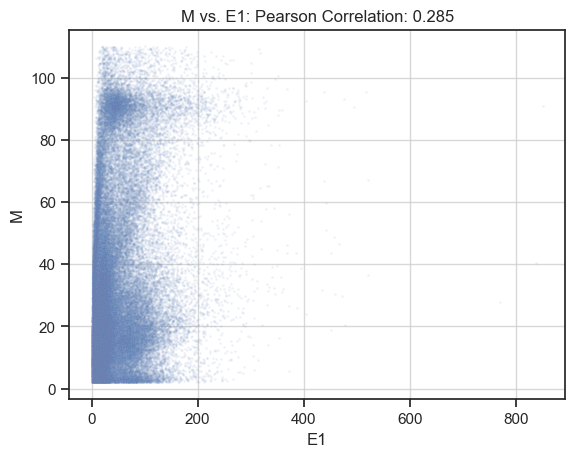

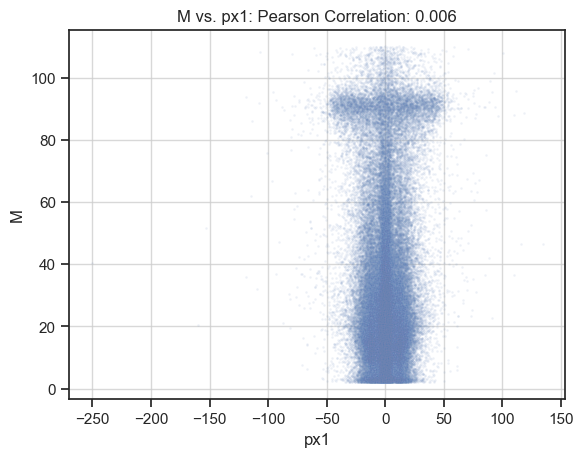

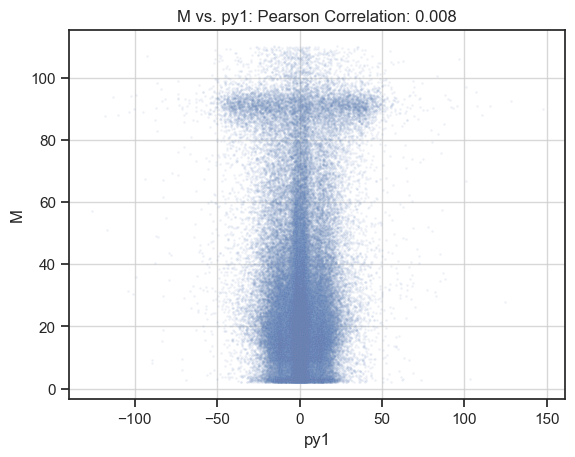

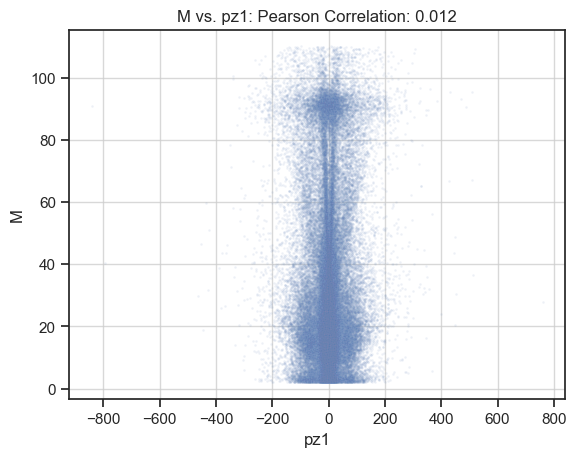

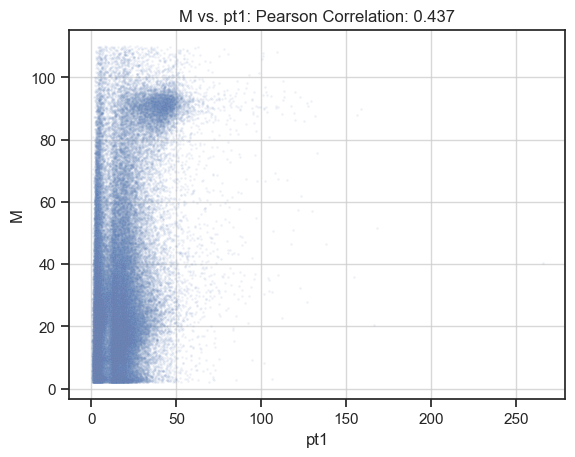

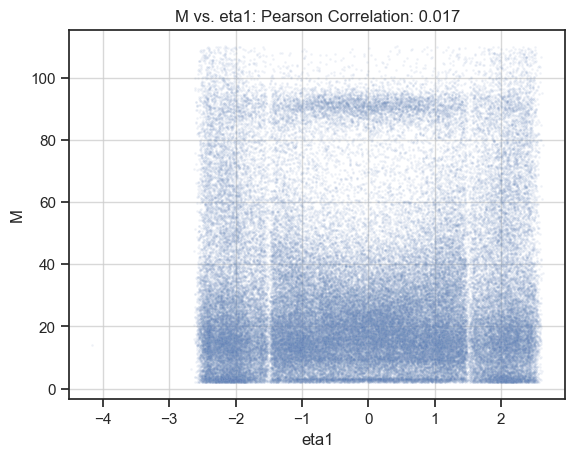

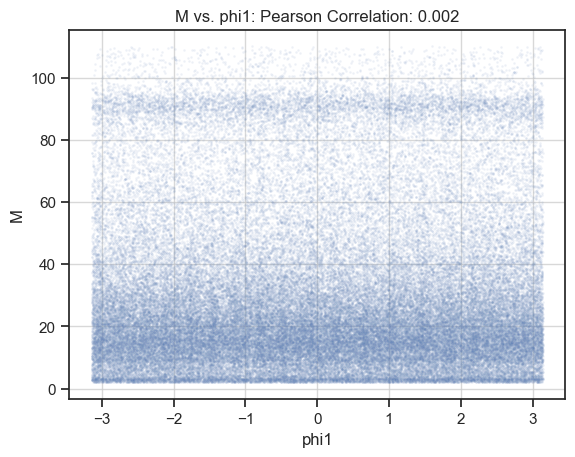

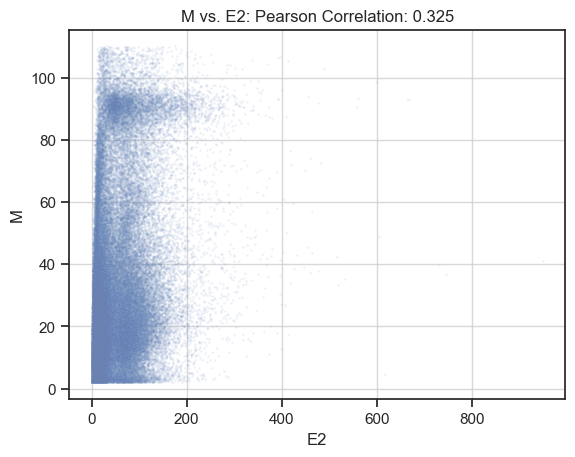

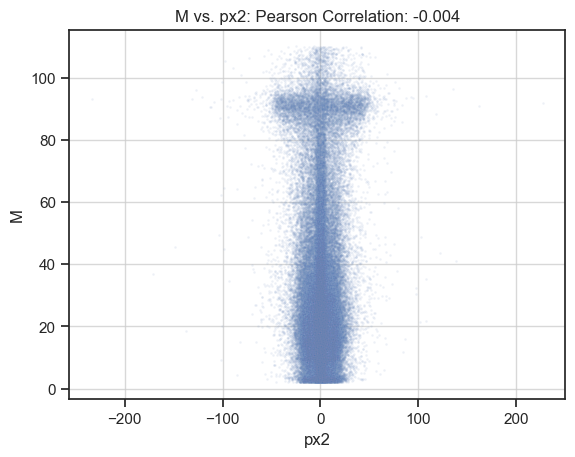

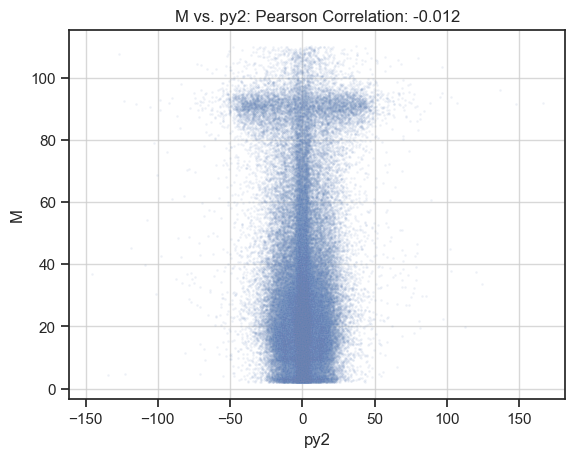

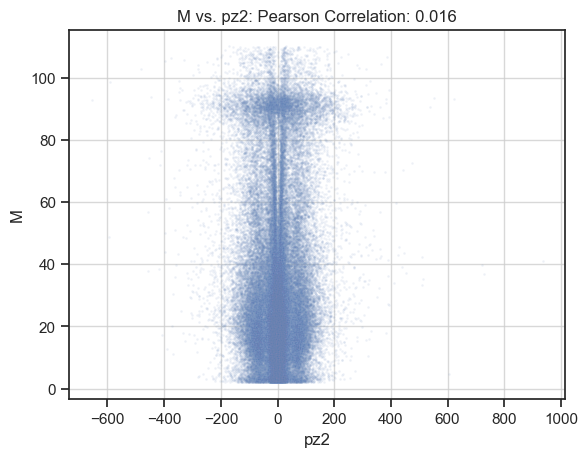

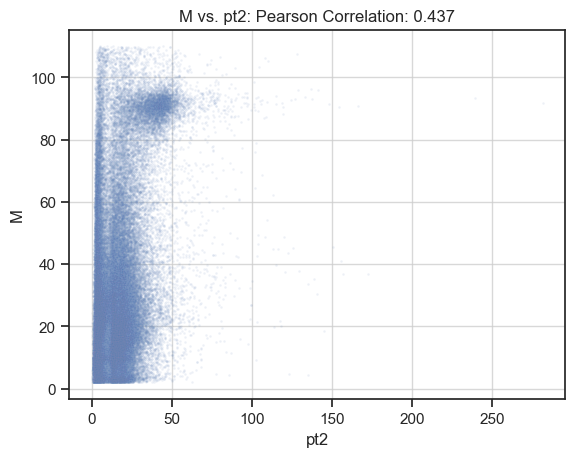

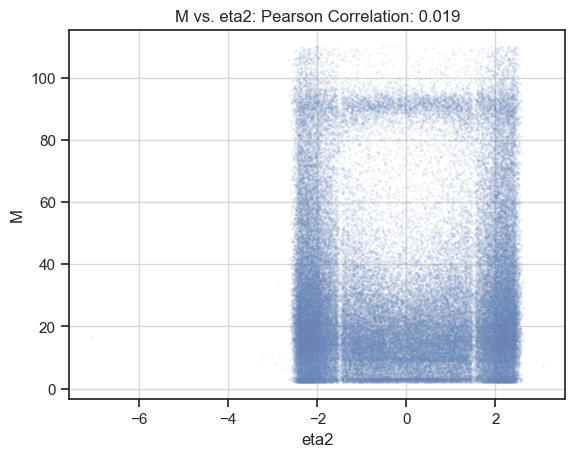

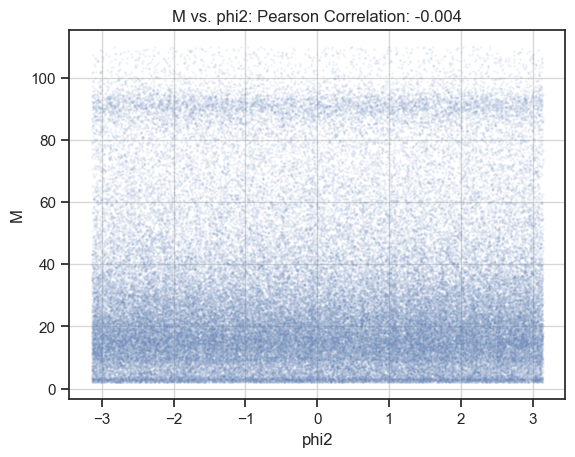

In [27]:
# Scatter plots of numerical features vs. target
for f in tqdm(numerical_features):
    corr_pearson = df[f].corr(df[target], method="pearson")  # Pearson correlation
    sns.scatterplot(x=f, y=target, data=df, s=3, alpha=0.1)  # Scatter plot
    plt.grid(alpha=0.75)  # Gridlines
    plt.title(
        f"{target} vs. {f}: Pearson Correlation: {corr_pearson.round(3)}"
    )  # Title
    plt.show()

* **Categorical** features vs. target

  0%|          | 0/2 [00:00<?, ?it/s]

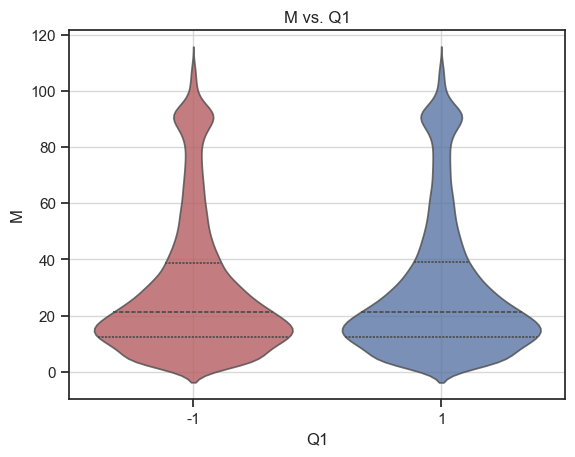

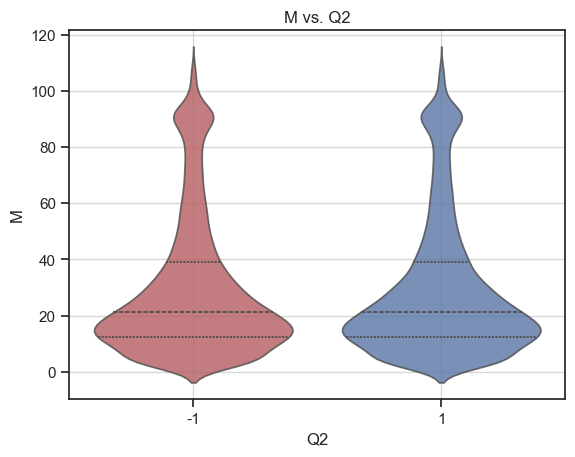

In [28]:
# Violin plots of target vs. charges
for f in tqdm(categorical_features):
    sns.violinplot(
        x=f,
        y=target,
        data=df,
        hue=f,
        inner="quartile",
        legend=False,
        palette=["r", "b"],
        alpha=0.8,
    )
    plt.grid(alpha=0.75)  # Gridlines
    plt.title(f"{target} vs. {f}")  # Title
    plt.show()

<a id='7'></a>
# **Building the Pipeline**

Our Pipeline will constitute four units: **Preprocessing**, **Feature Engineering**, **Scaling** and the **Model** itself. 

* The **preprocessing unit** will include the following steps: **feaure selection -> outlier removal/imputation**.

* The **feature engineering unit** will perform of **Feature Creation** to hopefully improve the model performance. Again, one could make this unit more elaborate by adding steps like Feature Selection, PCA, or Clustering. But we'll exclude those steps for now.

* The **scaling** unit will be used to standardize all numerical data before going to the model.

* Finally, the **model unit** will simply contain the machine learning algorithm that we'll make predictions with (in our case, a gradient boosted regressor). This is almost always the most simple and final component of a machine learning pipeline.

Once we have built our Pipeline, it will be easy for us to evaluate different models using **cross-validation** and **tune** their hyperparameters. With the added certainty that our preprocessing and feature engineering steps are applied to both the training and validation/test data. This is the power of pipelines!


In [29]:
X = df.drop(columns=[target])  # Features
y = df[target]  # Target

In [30]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, random_state=42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (69924, 18)
y_train shape: (69924,)
X_test shape: (29968, 18)
y_test shape: (29968,)


* Constructing custom transformers

In [31]:
class FeatureRemover(BaseEstimator, TransformerMixin):
    """
    - Custom Outlier Detector transformer that follows the Sklearn interface to be used in a Pipeline.
    - Example of a class that is inheriting from BaseEstimator & TransformerMixin.
    - Therefore we have to implement fit() and transform()
    - Note that fit_transform() is inherited from TransformerMixin.
    """

    def __init__(self, feature_names: list):
        """Initialize the transformer."""
        self.feature_names = feature_names

    def fit(self, X, y=None):
        """Do nothing."""
        return self

    def transform(self, X):
        """Remove features from the dataframe."""
        return X.drop(columns=self.feature_names).round(3)

In [32]:
class OutlierImputator(BaseEstimator, TransformerMixin):
    def __init__(self, n_neighbors=30, contamination=0.005, verbose=False):
        self.n_neighbors = n_neighbors
        self.contamination = contamination
        self.verbose = verbose

    def outliers_lof(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        """Detects outliers using the Local Outlier Factor (LOF) method and replaces them with the mean of each feature."""

        # Copy to protect original data
        X = X.copy()

        # Instantiate the LOF model
        lof = LocalOutlierFactor(
            n_neighbors=self.n_neighbors, contamination=self.contamination, n_jobs=-1
        )

        # Fit the model and get the predicted labels
        predictions = lof.fit_predict(X[numerical_features])

        # Get the indices of the outliers
        outliers = np.where(predictions == -1)[0]

        # Count the number of outliers
        num_outliers = len(outliers)

        # Replace outliers with the mean of each feature
        for i in outliers:
            X.iloc[i][numerical_features] = X[numerical_features].mean()

        if self.verbose:
            print("-" * 50)
            print("Outlier Imputation Report")
            print("-" * 50)
            print(f"Number of outliers: {num_outliers}")
            print(f"Percentage of outliers: {num_outliers / X.shape[0] * 100:.2f}%")

        return pd.DataFrame(X).round(3)

    def fit(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        """Do nothing."""
        return self

    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        """Transforms the data by applying and returning the outlier_lof() method."""
        return self.outliers_lof(X)

In [33]:
class CreateFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        """In this scenario, the fit method does nothing but it must be implemented to be used in a pipeline."""
        return self

    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        """Creates new features from the existing ones."""

        X = X.copy()  # Copy to protect input data
        X["total_energy"] = X["E1"] + X["E2"]  # Calculate total energy of the system

        # Calculate the product of the momenta components
        X["px12"] = X["px1"] * X["px2"]
        X["py12"] = X["py1"] * X["py2"]
        X["pz12"] = X["pz1"] * X["pz2"]

        # Calculate the product of the tranverse momenta
        X["pt12"] = X["pt1"] * X["pt2"]

        # Calculate the product of the charges
        X["Q12"] = X["Q1"] * X["Q2"]

        # Calculate the product of the pseudorapidities
        X["phi12"] = X["phi1"] * X["phi2"]
        X["eta12"] = X["eta1"] * X["eta2"]

        # Return dataframe with new features
        return pd.DataFrame(X).round(3)

Our custom CreateFeatures transformer creates the following new features:
- Total energy: E1 + E2
- Product of the momenta components: px1 * px2, py1 * py2, pz1 * pz2
- Product of the transverse momenta: pt1 * pt2
- Product of the charges: Q1 * Q2
- Product of the pseudorapidities: phi1 * phi2, eta1 * eta2

The motivation for creating these features is that
1) The total energy of a system is a conserved quantity in physics.
2) Kinetic energy is proportional to the square of momentum.
3) The product of the charges determines the type of interaction between the particles (attraction or repulsion).

In [34]:
def build_pipeline(model, with_feature_engineer=True) -> Pipeline:
    """Builds the final pipeline by combining the preprocessor, feature_engineer and the specified model."""

    # Defining the new numerical and categorical features (original + features created from CreateFeatures transformer)
    new_num_features = numerical_features + [
        "total_energy",
        "px12",
        "py12",
        "pz12",
        "pt12",
        "phi12",
        "eta12",
    ]
    new_cat_features = categorical_features + ["Q12"]

    # Step 1: Preprocessing
    preprocessor = make_pipeline(
        FeatureRemover(feature_names=["Run", "Event"]), OutlierImputator()
    )

    # Step 2: Feature Engineering
    feature_engineer = make_pipeline(CreateFeatures())

    # Step 3: Scaling (StandardScaler for numerical features and passthrough for categorical features)
    scaler = ColumnTransformer(
        [
            (
                "numerical",
                StandardScaler(),
                new_num_features if with_feature_engineer else numerical_features,
            ),
            (
                "categorical",
                "passthrough",
                new_cat_features if with_feature_engineer else categorical_features,
            ),
        ],
        verbose_feature_names_out=False,
    )

    return Pipeline(
        [
            ("preprocessor", preprocessor),
            (
                "feature_engineer",
                feature_engineer if with_feature_engineer else "passthrough",
            ),
            ("scaler", scaler),
            ("model", model),
        ]
    )

<a id='8'></a>
# **Model Selection w/o Feature Engineering**

In this section, we will **cross-validate** a number of different models without the feature engineering step in our pipeline.

In the next section, we will do the same but with the feature engineering unit included. 

The reason for this is that we want to see how much of an improvement (if any) the feature engineering step makes. Different models may benefit from feature engineering more than others, so it is important to compare the models with and without feature engineering before deciding on the best model to proceed with.

In [35]:
def perform_cross_val(
    pipeline, X, y, k=5, scoring="neg_root_mean_squared_error", verbose=3
):
    """Perform K-fold cross-validation and return the mean score."""

    # Set up the cross-validation strategy
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Perform cross-validation
    scores = cross_val_score(pipeline, X, y, cv=kf, scoring=scoring, verbose=verbose)

    # Take the absolute value of the scores (since we are using a negative scoring metric)
    scores = abs(scores)
    mean = scores.mean()
    std = scores.std()
    print("-" * 50)
    print(f"Model: {pipeline['model'].__class__.__name__}")
    print(f"CV RMSEs: {scores}")
    print(f"Mean RMSE : {mean:.3f}")
    print(f"Standard deviation of RMSE: {std:.3f}")
    print("-" * 50)

    return mean

In [36]:
# List of models to test
models = [
    XGBRegressor(random_state=42),
    LGBMRegressor(random_state=42, verbose=0),
    CatBoostRegressor(random_state=42, verbose=False),
]

In [37]:
# Dictionary to store the mean CV scores
cv_scores = {}

# Looping through the models and performing cross-validation for each model, storing the mean CV score in the dictionary
for model in tqdm(models):
    pipeline = build_pipeline(model, with_feature_engineer=False)
    cv_score = perform_cross_val(pipeline, X_train.copy(), y_train.copy())
    cv_scores[model.__class__.__name__] = cv_score

  0%|          | 0/3 [00:00<?, ?it/s]

[CV] END ............................... score: (test=-3.982) total time=   5.3s
[CV] END ............................... score: (test=-3.734) total time=   5.2s
[CV] END ............................... score: (test=-3.774) total time=   4.7s
[CV] END ............................... score: (test=-3.811) total time=   4.6s
[CV] END ............................... score: (test=-3.878) total time=   4.4s
--------------------------------------------------
Model: XGBRegressor
CV RMSEs: [3.9820917  3.73379817 3.77357775 3.81075407 3.87801   ]
Mean RMSE : 3.836
Standard deviation of RMSE: 0.087
--------------------------------------------------
[CV] END ............................... score: (test=-5.151) total time=   4.4s
[CV] END ............................... score: (test=-5.057) total time=   4.3s
[CV] END ............................... score: (test=-4.825) total time=   4.3s
[CV] END ............................... score: (test=-5.046) total time=   4.2s
[CV] END .....................

In [38]:
# Best model and its mean CV RMSE
best_model = min(cv_scores, key=cv_scores.get)
best_score = cv_scores[best_model]

print("-" * 50)
print(f"Best model: {best_model}")
print(f"Best CV score: {best_score:.3f}")
print("-" * 50)

--------------------------------------------------
Best model: CatBoostRegressor
Best CV score: 2.268
--------------------------------------------------


We can see that the clear **CatBoostRegressor** is the winner here, although it runs the slowest. But will it still be when we turn on our feature engineer?

<a id='9'></a>
# **Model Selection with Feature Engineering**

In [39]:
# Dictionary to store the mean CV scores
cv_scores_with_feature_engineer = {}

# Looping through the models and performing cross-validation for each model WITH feature engineering, storing the mean CV score in the dictionary
for model in tqdm(models):
    pipeline = build_pipeline(model, with_feature_engineer=True)
    cv_score = perform_cross_val(pipeline, X_train.copy(), y_train.copy())
    cv_scores_with_feature_engineer[model.__class__.__name__] = cv_score

  0%|          | 0/3 [00:00<?, ?it/s]

[CV] END ............................... score: (test=-1.708) total time=   4.5s
[CV] END ............................... score: (test=-1.657) total time=   4.7s
[CV] END ............................... score: (test=-1.743) total time=   4.4s
[CV] END ............................... score: (test=-1.657) total time=   4.4s
[CV] END ............................... score: (test=-1.766) total time=   4.4s
--------------------------------------------------
Model: XGBRegressor
CV RMSEs: [1.70770204 1.65725613 1.74267128 1.65677234 1.76633789]
Mean RMSE : 1.706
Standard deviation of RMSE: 0.044
--------------------------------------------------
[CV] END ............................... score: (test=-1.819) total time=   4.1s
[CV] END ............................... score: (test=-1.788) total time=   4.3s
[CV] END ............................... score: (test=-1.803) total time=   4.3s
[CV] END ............................... score: (test=-1.683) total time=   4.2s
[CV] END .....................

In [40]:
# Best model and its mean CV RMSE
best_model_with_feature_engineer = min(
    cv_scores_with_feature_engineer, key=cv_scores_with_feature_engineer.get
)
best_score_with_feature_engineer = cv_scores_with_feature_engineer[
    best_model_with_feature_engineer
]

print("-" * 50)
print(f"Best model with Feature Engineering: {best_model_with_feature_engineer}")
print(f"Best CV score with Feature Engineering: {best_score_with_feature_engineer:.3f}")
print("-" * 50)

--------------------------------------------------
Best model with Feature Engineering: CatBoostRegressor
Best CV score with Feature Engineering: 1.142
--------------------------------------------------


Again, CatBoostRegressor wins! It is the best model with and without feature engineering (but still the slowest). 

We can also see that by adding feature engineering to our pipeline, we improved the performance of all models, which is great news. 

In the next section, we will see if we can improve the performance of our model by tuning the hyperparameters using randomized grid search.

In [41]:
# Creating a pipeline with the best model
model = CatBoostRegressor(random_state=42, verbose=False)
catboost_pipe = build_pipeline(model, with_feature_engineer=True)

<a id='10'></a>
# **Tuning Hyperparameters**

Our baseline model with CatBoostRegressor and its default hyperparameters (no hyperparameter tuning) has a CV RMSE of 1.142 GeV, which is not bad at all! Let's see if we can improve it with hyperparameter tuning.

In [51]:
# Defining the hyperparameter grid
parmas = {
    "model__learning_rate": np.linspace(0.01, 0.3, 10),
    "model__iterations": np.arange(1000, 3100, 100),
    "model__depth": np.linspace(4, 10, 7),
    "model__l2_leaf_reg": np.linspace(1, 10, 10),
    "model__subsample": np.linspace(0.5, 1, 6),
    "model__colsample_bylevel": np.linspace(0.5, 1, 6),
}

# Instantiating RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=catboost_pipe,
    param_distributions=parmas,
    n_iter=10,
    cv=3,
    scoring="neg_root_mean_squared_error",
    error_score="raise",
    verbose=3,
    random_state=42,
)

# Creating a smaller training set to speed up the search process and avoid memory issues
rs_X_train = X_train.sample(frac=0.2, random_state=42)
rs_Y_train = y_train.sample(frac=0.2, random_state=42)

# Fitting the model
random_search.fit(rs_X_train, rs_Y_train)

# Results
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score = random_search.best_score_

print("-" * 50)
print("RandomizedSearchCV results:")
print("-" * 50)
print(f"Best parameters: {best_params}")
print(f"Best score: {best_score:.3f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END model__colsample_bylevel=0.6, model__depth=6.0, model__iterations=2400, model__l2_leaf_reg=3.0, model__learning_rate=0.20333333333333334, model__subsample=0.7;, score=-1.706 total time=   9.4s
[CV 2/3] END model__colsample_bylevel=0.6, model__depth=6.0, model__iterations=2400, model__l2_leaf_reg=3.0, model__learning_rate=0.20333333333333334, model__subsample=0.7;, score=-1.500 total time=   7.6s
[CV 3/3] END model__colsample_bylevel=0.6, model__depth=6.0, model__iterations=2400, model__l2_leaf_reg=3.0, model__learning_rate=0.20333333333333334, model__subsample=0.7;, score=-1.739 total time=   7.3s
[CV 1/3] END model__colsample_bylevel=0.6, model__depth=7.0, model__iterations=1900, model__l2_leaf_reg=9.0, model__learning_rate=0.2677777777777778, model__subsample=0.9;, score=-1.810 total time=  13.4s
[CV 2/3] END model__colsample_bylevel=0.6, model__depth=7.0, model__iterations=1900, model__l2_leaf_reg=9.0, model__

In [52]:
# Cross-validating the best model (with best parameters) on entire training set
perform_cross_val(best_model, X_train.copy(), y_train.copy())

[CV] END ............................... score: (test=-0.911) total time=  18.9s
[CV] END ............................... score: (test=-0.847) total time=  18.8s
[CV] END ............................... score: (test=-1.020) total time=  20.9s
[CV] END ............................... score: (test=-0.825) total time=  16.6s
[CV] END ............................... score: (test=-0.973) total time=  15.8s
--------------------------------------------------
Model: CatBoostRegressor
CV RMSEs: [0.91078494 0.84666745 1.01968817 0.82492161 0.97250884]
Mean RMSE : 0.915
Standard deviation of RMSE: 0.074
--------------------------------------------------


0.9149142029826794

The RandomizedSearchCV found a set of hyperparameters that reduced the RMSE by around 20% (from 1.14 GeV to 0.91 GeV), which is great. We could probably improve the model's performance even further by narrowing down the hyperparameter grid and using GridSearchCV, but we will stop here for now.

<a id='11'></a>
# **Final Evaluation**

In [53]:
def eval_model(pipeline, X_train, y_train, X_test, y_test):
    """
    Quickly trains model pipeline and evaluates it on train and test sets.
    """
    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Predictions
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    # Metrics
    rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
    rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    print("-" * 50)
    print(f"Regression model: {pipeline['model'].__class__.__name__}")
    print(f"Train RMSE: {rmse_train:.3f}")
    print(f"Test RMSE: {rmse_test:.3f}")
    print(f"Train R2: {r2_train:.3f}")
    print(f"Test R2: {r2_test:.3f}")
    print("-" * 50)

    # Plot predictions vs. actual values
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.scatterplot(x=y_test, y=y_pred_test, s=3, alpha=0.5)

    # Plotting R2 score
    x = np.linspace(0, 110, 100)
    sns.lineplot(x=x, y=(r2_test * x), color="r", label=f"R2 Score: {r2_test:.3f}")

    # Plot settings
    plt.grid(alpha=0.75)
    plt.title("Predictions vs. Actual Values")
    plt.xlabel("Actual Invariant Mass (GeV)")
    plt.ylabel("Predicted Invariant Mass (GeV)")
    plt.show()

--------------------------------------------------
Regression model: CatBoostRegressor
Train RMSE: 0.400
Test RMSE: 0.907
Train R2: 1.000
Test R2: 0.999
--------------------------------------------------


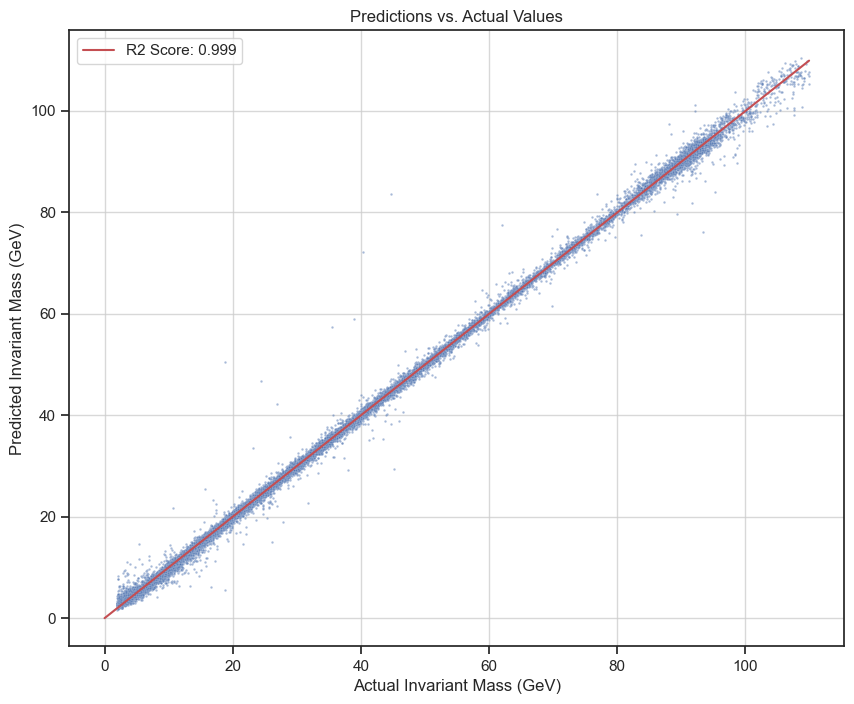

In [55]:
# Evaluating our best model (with best parameters) on the train and test sets
eval_model(best_model, X_train, y_train, X_test, y_test)

Our final model is quite impressive, with a test RMSE of 0.91 GeV and a test R2 score of 0.999! 

Let's save the model (pipeline) for future use, for example if we want to make predictions on new data like proton-proton collisions at the LHC. 

In [56]:
# Saving the model
import joblib

joblib.dump(best_model, "../models/best_model.pkl")

['../models/best_model.pkl']

<a id='12'></a>
# **Feature Importances**

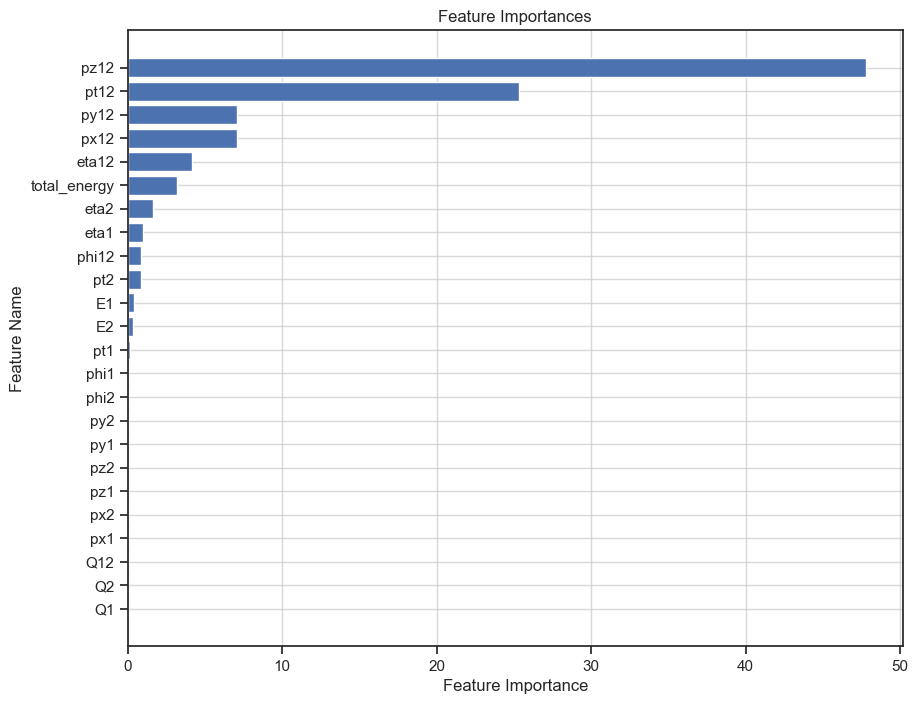

In [79]:
# Getting the feature importances
importances = best_model["model"].get_feature_importance()

# Getting the feature names
feature_names = best_model["model"].feature_names_

# Creating a series to store the feature importances with the feature names as the index
feature_importances = pd.Series(importances, index=feature_names).sort_values()

# Plotting the feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importances.index, feature_importances.values)
plt.title("Feature Importances")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.grid(alpha=0.75)
plt.show()

Our feature engineering definitely paid off! The most import features are the ones we created.

Physically, it makes sense that 'pz12' is the most important feature. The particle beams used to create the dielectron pairs travel along the z-axis, and since the invarient mass is proportional to the square of momentum, the z-component p1p2 should be the most important feature in predicting the invariant mass.